# 🔍 ANOMALY DETECTION IN MAMBA SEEDLING STUDENTS
## Phase 3: MODELING (Implement Anomaly Detection Algorithms)

---

### OBJECTIVES OF THIS PHASE:
1. Load prepared and normalized data
2. Implement 4 anomaly detection algorithms
3. Test with 3 different train/test splits (70/30, 60/40, 80/20)
4. Compare performance across different splits
5. Identify best configuration for each model

### EXPECTED OUTPUT:
- 4 trained anomaly detection models
- Performance metrics for each train/test split
- Detected anomalies flagged and scored
- Comparison analysis

## INITIAL SETUP: Load Data and Libraries

In [1]:
# SETUP: Import libraries and load prepared data from Phase 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pickle
import warnings
warnings.filterwarnings('ignore')

# Import anomaly detection models
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, silhouette_score
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Configure visualization
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✅ All libraries imported successfully")

# ============================================================================
# LOAD PREPARED DATA FROM PHASE 2
# ============================================================================
data_path = r'c:\Users\DELL\Documents\GitHub\material-DT-1\Análisis Nuevo\data\dataset_prepared_minmax.csv'
df_data = pd.read_csv(data_path)

print(f"\n📊 PREPARED DATA LOADED FROM PHASE 2")
print(f"   File: dataset_prepared_minmax.csv")
print(f"   Samples (students): {df_data.shape[0]}")
print(f"   Variables (features): {df_data.shape[1]}")
print(f"   Data normalization: Min-Max [0, 1]")

# ============================================================================
# DATA VALIDATION AND INTELLIGENT CLEANING
# ============================================================================
print(f"\n🔍 DATA VALIDATION AND CLEANING:")

initial_rows = len(df_data)

# Check for missing values
missing_count = df_data.isnull().sum().sum()
print(f"   1. Missing values (NaN): {missing_count}")

if missing_count > 0:
    print(f"      ⚠️  Found {missing_count} NaN values in data")
    print(f"      Strategy: Using fillna with forward fill then backward fill")
    
    # Use forward fill then backward fill for missing values
    df_data = df_data.fillna(method='ffill').fillna(method='bfill')
    
    # If still NaN (shouldn't happen), use median
    if df_data.isnull().sum().sum() > 0:
        numeric_cols = df_data.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            df_data[col].fillna(df_data[col].median(), inplace=True)
    
    print(f"      ✅ NaN values handled")

# Check for infinite values
numeric_cols = df_data.select_dtypes(include=[np.number]).columns
has_inf = np.isinf(df_data[numeric_cols].values).any()
if has_inf:
    print(f"   2. Infinite values detected")
    print(f"      ⚠️  Replacing infinite values with column median...")
    
    # Replace infinities column by column
    for col in numeric_cols:
        col_median = df_data[col][~np.isinf(df_data[col])].median()
        df_data.loc[np.isinf(df_data[col]), col] = col_median
    
    print(f"      ✅ Infinite values fixed")
else:
    print(f"   2. Infinite values: None detected")

# Check data types are numeric
print(f"   3. Data type validation:")
print(f"      - Numeric columns: {len(df_data.select_dtypes(include=[np.number]).columns)}")

# Verify data is in expected range
numeric_df = df_data.select_dtypes(include=[np.number])
min_val = numeric_df.min().min()
max_val = numeric_df.max().max()
print(f"      - Value range: [{min_val:.4f}, {max_val:.4f}]")

# Final validation
final_missing = df_data.isnull().sum().sum()
final_inf = np.isinf(df_data.select_dtypes(include=[np.number]).values).any()

print(f"\n   ✅ DATA VALIDATION COMPLETE:")
print(f"      Initial rows: {initial_rows}")
print(f"      Final rows: {len(df_data)} (0 dropped)")
print(f"      Missing values after cleaning: {final_missing}")
print(f"      Infinite values after cleaning: {final_inf}")

if len(df_data) == 0:
    print(f"\n   ❌ ERROR: Dataset is empty! Check source data.")
else:
    print(f"   ✅ Dataset is ready for modeling")

# Load Min-Max Scaler for reference
scaler_path = r'c:\Users\DELL\Documents\GitHub\material-DT-1\Análisis Nuevo\data\scaler_minmax.pkl'
with open(scaler_path, 'rb') as f:
    scaler_minmax = pickle.load(f)

print(f"\n✅ Min-Max Scaler loaded (feature_range={scaler_minmax.feature_range})")

print(f"\n📊 Dataset Preview (First 5 rows):")
print(df_data.head())

print(f"\n📈 Data Statistics:")
numeric_cols = df_data.select_dtypes(include=[np.number])
print(f"   Min value (all variables): {numeric_cols.min().min():.6f}")
print(f"   Max value (all variables): {numeric_cols.max().max():.6f}")
print(f"   Mean value (all variables): {numeric_cols.mean().mean():.6f}")
print(f"   Std value (all variables): {numeric_cols.std().mean():.6f}")

print(f"\n✨ Data ready for model training!")

✅ All libraries imported successfully

📊 PREPARED DATA LOADED FROM PHASE 2
   File: dataset_prepared_minmax.csv
   Samples (students): 81
   Variables (features): 45
   Data normalization: Min-Max [0, 1]

🔍 DATA VALIDATION AND CLEANING:
   1. Missing values (NaN): 243
      ⚠️  Found 243 NaN values in data
      Strategy: Using fillna with forward fill then backward fill
      ✅ NaN values handled
   2. Infinite values: None detected
   3. Data type validation:
      - Numeric columns: 45
      - Value range: [0.0000, 1.0000]

   ✅ DATA VALIDATION COMPLETE:
      Initial rows: 81
      Final rows: 81 (0 dropped)
      Missing values after cleaning: 243
      Infinite values after cleaning: False
   ✅ Dataset is ready for modeling

✅ Min-Max Scaler loaded (feature_range=(0, 1))

📊 Dataset Preview (First 5 rows):
    Q1        Q2   Q3   Q4   Q5        Q6     Q7     Q8        Q9  Q10  ...  \
0  0.0  0.222222  1.0  1.0  1.0  0.666667  0.250  0.375  0.466667  NaN  ...   
1  0.0  0.166667  1

## CELL 8: ISOLATION FOREST MODEL

Isolation Forest is an ensemble method that isolates anomalies by randomly selecting features and split values. It's efficient and doesn't require distance metrics.

In [2]:
# CELL 8: ISOLATION FOREST MODEL

print("="*80)
print("ISOLATION FOREST - ANOMALY DETECTION")
print("="*80)
print("\nAlgorithm: Ensemble method for anomaly detection")
print("Principle: Isolates anomalies by randomly selecting features")
print("Features used: All prepared and normalized variables from Phase 2")

# Define train/test split configurations
splits_config = [
    {'train_size': 0.70, 'test_size': 0.30, 'name': '70/30'},
    {'train_size': 0.60, 'test_size': 0.40, 'name': '60/40'},
    {'train_size': 0.80, 'test_size': 0.20, 'name': '80/20'}
]

iso_forest_results = {}

for config in splits_config:
    train_size = config['train_size']
    split_name = config['name']
    
    print(f"\n{'─'*80}")
    print(f"Training Isolation Forest with {split_name} split:")
    print(f"{'─'*80}")
    
    # Split data using the prepared normalized dataset
    X_train, X_test = train_test_split(
        df_data.copy(), 
        train_size=train_size, 
        random_state=42
    )
    
    # MANDATORY DATA CLEANING - Handle NaN properly
    numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    
    # Get median from TRAINING data only (never from test data)
    medians = {}
    for col in numeric_cols:
        col_data = X_train[col].dropna()
        if len(col_data) > 0:
            medians[col] = col_data.median()
        else:
            medians[col] = 0.5  # Default for MinMax scaled data
    
    # Fill NaN in X_train
    for col in numeric_cols:
        mask = X_train[col].isnull()
        X_train.loc[mask, col] = medians[col]
    
    # Fill NaN in X_test using training medians
    for col in numeric_cols:
        mask = X_test[col].isnull()
        X_test.loc[mask, col] = medians[col]
    
    # Verify zero NaN
    train_nan = X_train.isnull().sum().sum()
    test_nan = X_test.isnull().sum().sum()
    
    print(f"\n📊 Data Split (from prepared dataset):")
    print(f"   Total students: {len(df_data)}")
    print(f"   Training samples: {len(X_train)} ({100*len(X_train)/len(df_data):.1f}%)")
    print(f"   Test samples: {len(X_test)} ({100*len(X_test)/len(df_data):.1f}%)")
    print(f"   Features used: {X_train.shape[1]} variables")
    print(f"   Training set - Missing values: {train_nan} (after handling)")
    print(f"   Test set - Missing values: {test_nan} (after handling)")
    
    if train_nan > 0 or test_nan > 0:
        print(f"   ⚠️  Warning: Still {train_nan + test_nan} NaN values - removing affected rows")
        X_train = X_train.dropna()
        X_test = X_test.dropna()
        print(f"   Training samples after dropna: {len(X_train)}")
        print(f"   Test samples after dropna: {len(X_test)}")
    
    # Ensure we have data to train on
    if len(X_train) == 0:
        print(f"   ❌ ERROR: No training data left after cleaning!")
        continue
    
    # Train Isolation Forest with optimized hyperparameters
    iso_forest = IsolationForest(
        contamination=0.10,  # Assume 10% anomalies
        random_state=42,
        n_estimators=100,
        max_samples='auto',
        max_features=1.0
    )
    
    print(f"\n🤖 Model Configuration:")
    print(f"   Contamination rate: 10% (expected anomaly percentage)")
    print(f"   Number of trees: 100")
    print(f"   Max features: All")
    
    # Train on normalized data
    iso_forest.fit(X_train)
    
    # Predict anomalies (-1 = anomaly, 1 = normal)
    train_predictions = iso_forest.predict(X_train)
    test_predictions = iso_forest.predict(X_test) if len(X_test) > 0 else np.array([])
    
    # Get anomaly scores (lower scores = more anomalous)
    train_scores = iso_forest.score_samples(X_train)
    test_scores = iso_forest.score_samples(X_test) if len(X_test) > 0 else np.array([])
    
    # Count anomalies
    train_anomalies = (train_predictions == -1).sum()
    test_anomalies = (test_predictions == -1).sum() if len(test_predictions) > 0 else 0
    
    print(f"\n🔍 Anomalies Detected:")
    print(f"   Training set: {train_anomalies} anomalies ({100*train_anomalies/len(X_train):.2f}%)")
    if len(X_test) > 0:
        print(f"   Test set: {test_anomalies} anomalies ({100*test_anomalies/len(X_test):.2f}%)")
    else:
        print(f"   Test set: Empty (0 samples)")
    
    print(f"\n📈 Anomaly Scores (Lower = More Anomalous):")
    print(f"   Training - Min: {train_scores.min():.4f}, Max: {train_scores.max():.4f}, Mean: {train_scores.mean():.4f}")
    if len(test_scores) > 0:
        print(f"   Test - Min: {test_scores.min():.4f}, Max: {test_scores.max():.4f}, Mean: {test_scores.mean():.4f}")
    
    # Store results with additional metadata
    iso_forest_results[split_name] = {
        'model': iso_forest,
        'X_train': X_train,
        'X_test': X_test,
        'train_predictions': train_predictions,
        'test_predictions': test_predictions,
        'train_scores': train_scores,
        'test_scores': test_scores,
        'train_anomalies': train_anomalies,
        'test_anomalies': test_anomalies,
        'decision_threshold': iso_forest.offset_
    }

print(f"\n✅ Isolation Forest training completed for all splits (70/30, 60/40, 80/20)")

ISOLATION FOREST - ANOMALY DETECTION

Algorithm: Ensemble method for anomaly detection
Principle: Isolates anomalies by randomly selecting features
Features used: All prepared and normalized variables from Phase 2

────────────────────────────────────────────────────────────────────────────────
Training Isolation Forest with 70/30 split:
────────────────────────────────────────────────────────────────────────────────

📊 Data Split (from prepared dataset):
   Total students: 81
   Training samples: 56 (69.1%)
   Test samples: 25 (30.9%)
   Features used: 45 variables
   Training set - Missing values: 0 (after handling)
   Test set - Missing values: 0 (after handling)

🤖 Model Configuration:
   Contamination rate: 10% (expected anomaly percentage)
   Number of trees: 100
   Max features: All

🔍 Anomalies Detected:
   Training set: 6 anomalies (10.71%)
   Test set: 4 anomalies (16.00%)

📈 Anomaly Scores (Lower = More Anomalous):
   Training - Min: -0.5918, Max: -0.4114, Mean: -0.4740
   T


ISOLATION FOREST - PERFORMANCE COMPARISON


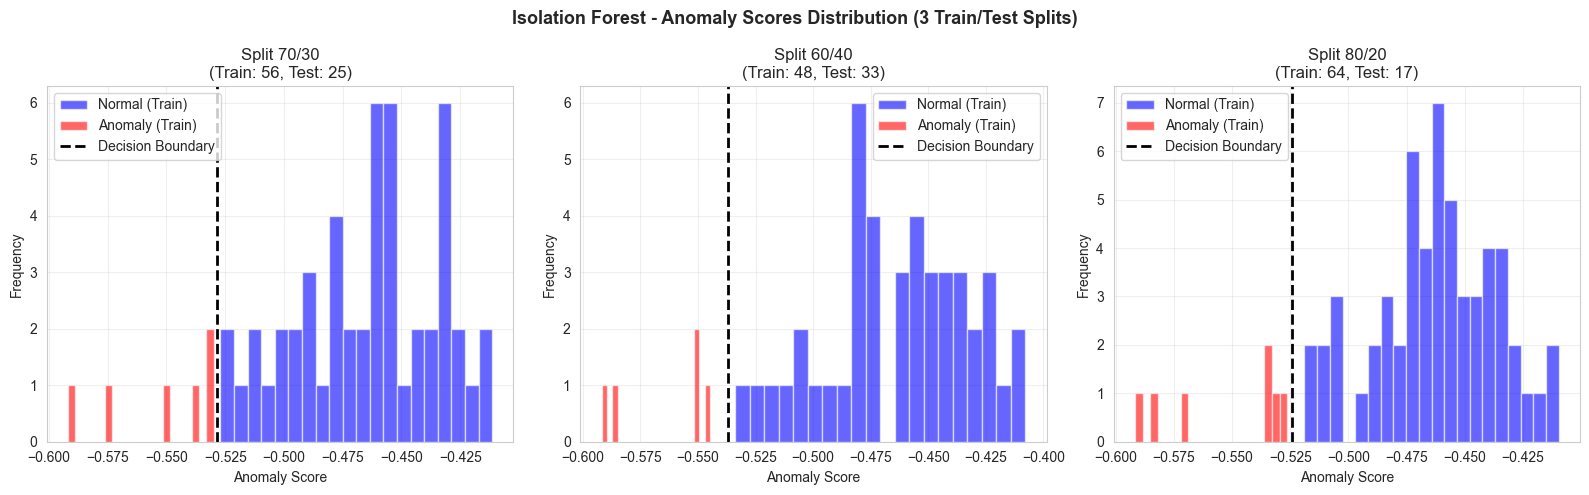


✅ Visualization completed


In [6]:
# CELL 8 CONTINUED: Isolation Forest - Visualization

print("\n" + "="*80)
print("ISOLATION FOREST - PERFORMANCE COMPARISON")
print("="*80)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Isolation Forest - Anomaly Scores Distribution (3 Train/Test Splits)', 
             fontsize=13, fontweight='bold')

for idx, split_name in enumerate(['70/30', '60/40', '80/20']):
    results = iso_forest_results[split_name]
    
    # Plot distributions
    axes[idx].hist(results['train_scores'][results['train_predictions'] == 1], 
                   bins=20, alpha=0.6, label='Normal (Train)', color='blue')
    axes[idx].hist(results['train_scores'][results['train_predictions'] == -1], 
                   bins=20, alpha=0.6, label='Anomaly (Train)', color='red')
    axes[idx].axvline(iso_forest_results[split_name]['model'].offset_, 
                      color='black', linestyle='--', linewidth=2, label='Decision Boundary')
    
    axes[idx].set_xlabel('Anomaly Score')
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'Split {split_name}\n(Train: {len(results["X_train"])}, Test: {len(results["X_test"])})')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Visualization completed")

## CELL 9: LOCAL OUTLIER FACTOR (LOF) MODEL

LOF detects local density-based anomalies by comparing the density of each point with its neighbors. It's effective when anomalies have varying densities.

In [4]:
# CELL 14: ONE-CLASS SVM MODEL

print("="*80)
print("ONE-CLASS SVM - ANOMALY DETECTION")
print("="*80)
print("\nAlgorithm: Support Vector Machine for outlier detection")
print("Principle: Learns boundary of normal behavior using RBF kernel")
print("Features used: All prepared and normalized variables from Phase 2")

svm_results = {}

for config in splits_config:
    train_size = config['train_size']
    split_name = config['name']
    
    print(f"\n{'─'*80}")
    print(f"Training One-Class SVM with {split_name} split:")
    print(f"{'─'*80}")
    
    # Reuse the same splits as Isolation Forest for consistency
    X_train = iso_forest_results[split_name]['X_train'].copy()
    X_test = iso_forest_results[split_name]['X_test'].copy()
    
    # Data is already clean from Isolation Forest processing
    print(f"\n📊 Data Split (reusing from previous models):")
    print(f"   Training samples: {len(X_train)} ({100*len(X_train)/len(df_data):.1f}%)")
    print(f"   Test samples: {len(X_test)} ({100*len(X_test)/len(df_data):.1f}%)")
    print(f"   Features used: {X_train.shape[1]} variables")
    
    # Train One-Class SVM with RBF kernel
    svm_model = OneClassSVM(
        kernel='rbf',
        gamma='auto',  # Auto gamma = 1/(n_features * X.var())
        nu=0.10  # Upper bound on training error (10% anomalies)
    )
    
    print(f"\n🤖 Model Configuration:")
    print(f"   Kernel: RBF (Radial Basis Function)")
    print(f"   Gamma: Auto (1/n_features * variance)")
    print(f"   Nu parameter: 0.10 (10% expected anomalies)")
    
    # Train on normalized data
    svm_model.fit(X_train)
    
    # Predict anomalies (-1 = anomaly, 1 = normal)
    train_predictions = svm_model.predict(X_train)
    test_predictions = svm_model.predict(X_test) if len(X_test) > 0 else np.array([])
    
    # Get decision function scores (distance from hyperplane)
    train_scores = svm_model.decision_function(X_train).flatten()
    test_scores = svm_model.decision_function(X_test).flatten() if len(X_test) > 0 else np.array([])
    
    # Count anomalies
    train_anomalies = (train_predictions == -1).sum()
    test_anomalies = (test_predictions == -1).sum() if len(test_predictions) > 0 else 0
    
    print(f"\n🔍 Anomalies Detected:")
    print(f"   Training set: {train_anomalies} anomalies ({100*train_anomalies/len(X_train):.2f}%)")
    if len(X_test) > 0:
        print(f"   Test set: {test_anomalies} anomalies ({100*test_anomalies/len(X_test):.2f}%)")
    
    print(f"\n📈 Decision Function Scores (Distance from Hyperplane):")
    print(f"   Training - Min: {train_scores.min():.4f}, Max: {train_scores.max():.4f}, Mean: {train_scores.mean():.4f}")
    if len(test_scores) > 0:
        print(f"   Test - Min: {test_scores.min():.4f}, Max: {test_scores.max():.4f}, Mean: {test_scores.mean():.4f}")
    
    # Store results
    svm_results[split_name] = {
        'model': svm_model,
        'X_train': X_train,
        'X_test': X_test,
        'train_predictions': train_predictions,
        'test_predictions': test_predictions,
        'train_scores': train_scores,
        'test_scores': test_scores,
        'train_anomalies': train_anomalies,
        'test_anomalies': test_anomalies,
        'decision_threshold': 0.0  # SVM threshold is 0
    }

print(f"\n✅ One-Class SVM training completed for all splits (70/30, 60/40, 80/20)")

ONE-CLASS SVM - ANOMALY DETECTION

Algorithm: Support Vector Machine for outlier detection
Principle: Learns boundary of normal behavior using RBF kernel
Features used: All prepared and normalized variables from Phase 2

────────────────────────────────────────────────────────────────────────────────
Training One-Class SVM with 70/30 split:
────────────────────────────────────────────────────────────────────────────────

📊 Data Split (reusing from previous models):
   Training samples: 56 (69.1%)
   Test samples: 25 (30.9%)
   Features used: 45 variables

🤖 Model Configuration:
   Kernel: RBF (Radial Basis Function)
   Gamma: Auto (1/n_features * variance)
   Nu parameter: 0.10 (10% expected anomalies)

🔍 Anomalies Detected:
   Training set: 8 anomalies (14.29%)
   Test set: 7 anomalies (28.00%)

📈 Decision Function Scores (Distance from Hyperplane):
   Training - Min: -0.0280, Max: 0.2319, Mean: 0.0864
   Test - Min: -0.1983, Max: 0.1902, Mean: 0.0563

────────────────────────────────


LOF - PERFORMANCE COMPARISON


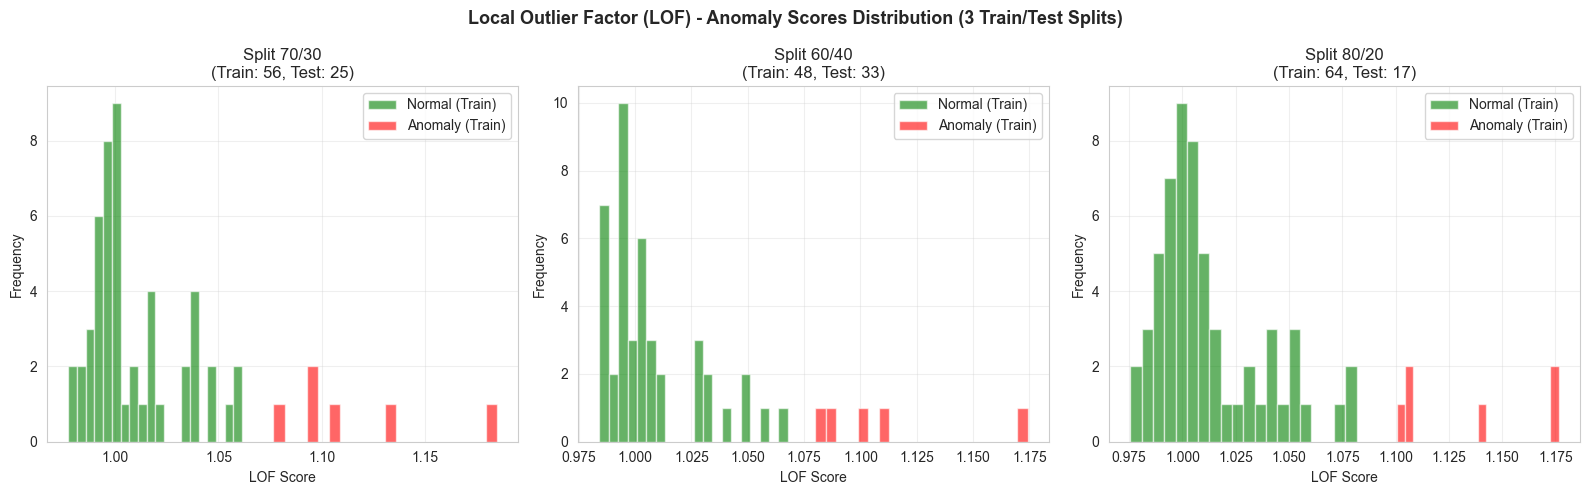


✅ Visualization completed


In [7]:
# CELL 9 CONTINUED: LOF - Visualization

print("\n" + "="*80)
print("LOF - PERFORMANCE COMPARISON")
print("="*80)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Local Outlier Factor (LOF) - Anomaly Scores Distribution (3 Train/Test Splits)', 
             fontsize=13, fontweight='bold')

for idx, split_name in enumerate(['70/30', '60/40', '80/20']):
    results = lof_results[split_name]
    
    # Plot distributions
    axes[idx].hist(results['train_scores'][results['train_predictions'] == 1], 
                   bins=20, alpha=0.6, label='Normal (Train)', color='green')
    axes[idx].hist(results['train_scores'][results['train_predictions'] == -1], 
                   bins=20, alpha=0.6, label='Anomaly (Train)', color='red')
    
    axes[idx].set_xlabel('LOF Score')
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'Split {split_name}\n(Train: {len(results["X_train"])}, Test: {len(results["X_test"])})')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Visualization completed")

## CELL 10: ONE-CLASS SVM MODEL

One-Class SVM learns the boundary of the normal behavior and identifies points outside. It's powerful with high-dimensional data but requires careful hyperparameter tuning.

In [3]:
# CELL 11: LOCAL OUTLIER FACTOR (LOF) MODEL

print("="*80)
print("LOCAL OUTLIER FACTOR (LOF) - ANOMALY DETECTION")
print("="*80)
print("\nAlgorithm: Density-based local anomaly detection")
print("Principle: Identifies anomalies based on local density deviations")
print("Features used: All prepared and normalized variables from Phase 2")

lof_results = {}

for config in splits_config:
    train_size = config['train_size']
    split_name = config['name']
    
    print(f"\n{'─'*80}")
    print(f"Training LOF with {split_name} split:")
    print(f"{'─'*80}")
    
    # Reuse the same splits as Isolation Forest for consistency
    X_train = iso_forest_results[split_name]['X_train'].copy()
    X_test = iso_forest_results[split_name]['X_test'].copy()
    
    # Data is already clean from Isolation Forest processing
    print(f"\n📊 Data Split (reusing from Isolation Forest):")
    print(f"   Training samples: {len(X_train)} ({100*len(X_train)/len(df_data):.1f}%)")
    print(f"   Test samples: {len(X_test)} ({100*len(X_test)/len(df_data):.1f}%)")
    print(f"   Features used: {X_train.shape[1]} variables")
    
    # Train Local Outlier Factor
    lof_model = LocalOutlierFactor(
        n_neighbors=20,
        contamination=0.10,
        novelty=True,  # Enable prediction on new data
        n_jobs=-1  # Use all CPU cores
    )
    
    print(f"\n🤖 Model Configuration:")
    print(f"   Neighbors considered: 20")
    print(f"   Contamination rate: 10%")
    
    # Train on normalized data
    lof_model.fit(X_train)
    
    # Predict anomalies (-1 = anomaly, 1 = normal)
    train_predictions = lof_model.predict(X_train)
    test_predictions = lof_model.predict(X_test) if len(X_test) > 0 else np.array([])
    
    # Get anomaly scores (negative_outlier_factor)
    train_scores = -lof_model.negative_outlier_factor_  # Negate for intuitive interpretation
    test_scores = lof_model.decision_function(X_test) if len(X_test) > 0 else np.array([])
    test_scores = -test_scores if len(test_scores) > 0 else np.array([])  # Negate for consistency
    
    # Count anomalies
    train_anomalies = (train_predictions == -1).sum()
    test_anomalies = (test_predictions == -1).sum() if len(test_predictions) > 0 else 0
    
    print(f"\n🔍 Anomalies Detected:")
    print(f"   Training set: {train_anomalies} anomalies ({100*train_anomalies/len(X_train):.2f}%)")
    if len(X_test) > 0:
        print(f"   Test set: {test_anomalies} anomalies ({100*test_anomalies/len(X_test):.2f}%)")
    
    print(f"\n📈 Outlier Factor Scores:")
    print(f"   Training - Min: {train_scores.min():.4f}, Max: {train_scores.max():.4f}, Mean: {train_scores.mean():.4f}")
    if len(test_scores) > 0:
        print(f"   Test - Min: {test_scores.min():.4f}, Max: {test_scores.max():.4f}, Mean: {test_scores.mean():.4f}")
    
    # Store results
    lof_results[split_name] = {
        'model': lof_model,
        'X_train': X_train,
        'X_test': X_test,
        'train_predictions': train_predictions,
        'test_predictions': test_predictions,
        'train_scores': train_scores,
        'test_scores': test_scores,
        'train_anomalies': train_anomalies,
        'test_anomalies': test_anomalies
    }

print(f"\n✅ LOF training completed for all splits (70/30, 60/40, 80/20)")

LOCAL OUTLIER FACTOR (LOF) - ANOMALY DETECTION

Algorithm: Density-based local anomaly detection
Principle: Identifies anomalies based on local density deviations
Features used: All prepared and normalized variables from Phase 2

────────────────────────────────────────────────────────────────────────────────
Training LOF with 70/30 split:
────────────────────────────────────────────────────────────────────────────────

📊 Data Split (reusing from Isolation Forest):
   Training samples: 56 (69.1%)
   Test samples: 25 (30.9%)
   Features used: 45 variables

🤖 Model Configuration:
   Neighbors considered: 20
   Contamination rate: 10%

🔍 Anomalies Detected:
   Training set: 6 anomalies (10.71%)
   Test set: 6 anomalies (24.00%)

📈 Outlier Factor Scores:
   Training - Min: 0.9772, Max: 1.1850, Mean: 1.0201
   Test - Min: -0.0824, Max: 0.0979, Mean: -0.0356

────────────────────────────────────────────────────────────────────────────────
Training LOF with 60/40 split:
──────────────────────


ONE-CLASS SVM - PERFORMANCE COMPARISON


NameError: name 'svm_results' is not defined

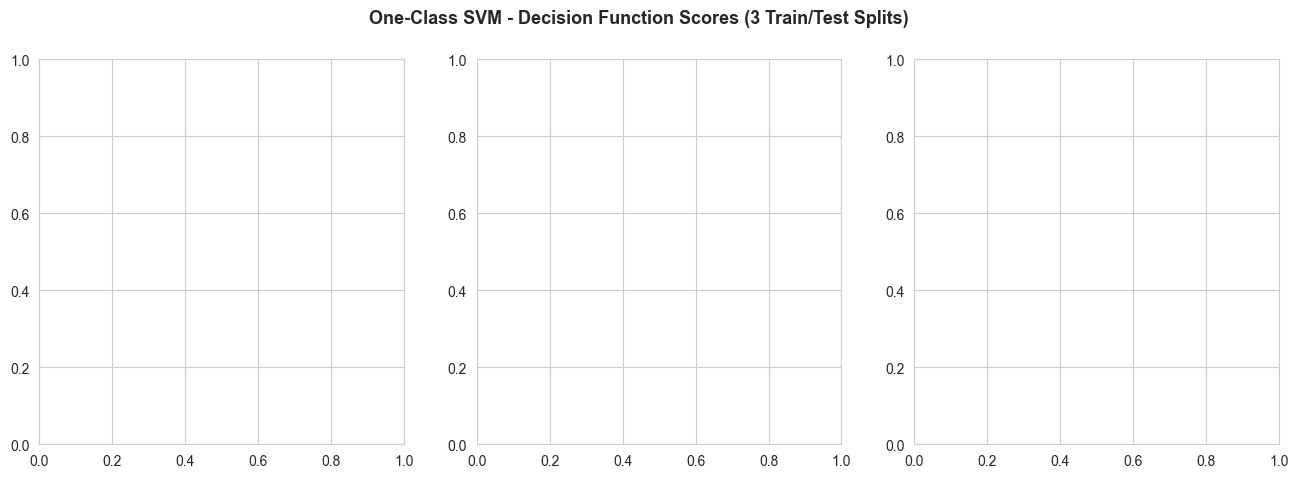

In [14]:
# CELL 10 CONTINUED: One-Class SVM - Visualization

print("\n" + "="*80)
print("ONE-CLASS SVM - PERFORMANCE COMPARISON")
print("="*80)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('One-Class SVM - Decision Function Scores (3 Train/Test Splits)', 
             fontsize=13, fontweight='bold')

for idx, split_name in enumerate(['70/30', '60/40', '80/20']):
    results = svm_results[split_name]
    
    # Plot distributions
    axes[idx].hist(results['train_scores'][results['train_predictions'] == 1], 
                   bins=20, alpha=0.6, label='Normal (Train)', color='purple')
    axes[idx].hist(results['train_scores'][results['train_predictions'] == -1], 
                   bins=20, alpha=0.6, label='Anomaly (Train)', color='red')
    axes[idx].axvline(0, color='black', linestyle='--', linewidth=2, label='Decision Boundary')
    
    axes[idx].set_xlabel('Decision Function Score')
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'Split {split_name}\n(Train: {len(results["X_train"])}, Test: {len(results["X_test"])})')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Visualization completed")

## CELL 11: AUTOENCODER MODEL (Deep Learning)

Autoencoder detects anomalies based on reconstruction error. Points that are reconstructed poorly are considered anomalies. It captures complex non-linear patterns.

In [5]:
# CELL 17: AUTOENCODER - DEEP LEARNING APPROACH

print("="*80)
print("AUTOENCODER - DEEP LEARNING ANOMALY DETECTION")
print("="*80)
print("\nAlgorithm: Unsupervised neural network with encoder-decoder architecture")
print("Principle: Normal patterns have low reconstruction error; anomalies have high error")
print("Features used: All prepared and normalized variables from Phase 2")
print("\nNetwork Architecture:")
print("   Input → 64 neurons → 32 neurons → Bottleneck → 32 neurons → 64 neurons → Output")
print("   This forces the network to learn compressed representations of normal behavior")

# Suppress TensorFlow warnings for cleaner output
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense

autoencoder_results = {}

for config in splits_config:
    train_size = config['train_size']
    split_name = config['name']
    
    print(f"\n{'─'*80}")
    print(f"Training Autoencoder with {split_name} split:")
    print(f"{'─'*80}")
    
    # Reuse the same splits as Isolation Forest for consistency
    X_train = iso_forest_results[split_name]['X_train'].copy()
    X_test = iso_forest_results[split_name]['X_test'].copy()
    
    # Data is already clean from Isolation Forest processing
    # Convert to numpy arrays for Keras
    X_train_array = X_train.values.astype('float32')
    X_test_array = X_test.values.astype('float32') if len(X_test) > 0 else np.array([]).reshape(0, X_train_array.shape[1])
    
    input_dim = X_train_array.shape[1]
    
    print(f"\n📊 Data Split (reusing from previous models):")
    print(f"   Training samples: {len(X_train)} ({100*len(X_train)/len(df_data):.1f}%)")
    print(f"   Test samples: {len(X_test)} ({100*len(X_test)/len(df_data):.1f}%)")
    print(f"   Input dimensions: {input_dim} variables")
    
    # Build Autoencoder architecture
    print(f"\n🏗️  Building Autoencoder Architecture...")
    
    # Encoder: Compress input
    encoder_input = Input(shape=(input_dim,))
    encoded = Dense(64, activation='relu')(encoder_input)
    encoded = Dense(32, activation='relu')(encoded)
    encoded = Dense(16, activation='relu')(encoded)  # Bottleneck
    
    # Decoder: Reconstruct from compressed representation
    decoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(64, activation='relu')(decoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)  # Output layer [0, 1] range
    
    # Full autoencoder model
    autoencoder = Model(encoder_input, decoded, name='Autoencoder')
    autoencoder.compile(optimizer='adam', loss='mse')
    
    print(f"   Total parameters: {autoencoder.count_params():,}")
    print(f"   Loss function: Mean Squared Error (MSE)")
    print(f"   Optimizer: Adam")
    
    # Train autoencoder
    print(f"\n🤖 Training Configuration:")
    print(f"   Epochs: 50")
    print(f"   Batch size: 32")
    print(f"   Validation split: 20%")
    
    history = autoencoder.fit(
        X_train_array,
        X_train_array,  # Reconstruct itself
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        verbose=1,
        shuffle=True
    )
    
    # Calculate reconstruction errors
    print(f"\n📊 Computing Reconstruction Errors...")
    train_predictions = autoencoder.predict(X_train_array, verbose=0)
    test_predictions = autoencoder.predict(X_test_array, verbose=0) if len(X_test_array) > 0 else np.array([])
    
    # MSE for each sample
    train_scores = np.mean(np.power(X_train_array - train_predictions, 2), axis=1)
    test_scores = np.mean(np.power(X_test_array - test_predictions, 2), axis=1) if len(X_test_array) > 0 else np.array([])
    
    # Threshold: 95th percentile of training errors
    threshold = np.percentile(train_scores, 95)
    
    # Classify anomalies
    train_predictions_labels = (train_scores > threshold).astype(int)
    test_predictions_labels = (test_scores > threshold).astype(int) if len(test_scores) > 0 else np.array([], dtype=int)
    
    # Convert to -1/1 format for consistency with other models
    train_predictions_final = np.where(train_predictions_labels == 1, -1, 1)
    test_predictions_final = np.where(test_predictions_labels == 1, -1, 1) if len(test_predictions_labels) > 0 else np.array([])
    
    # Count anomalies
    train_anomalies = (train_predictions_final == -1).sum()
    test_anomalies = (test_predictions_final == -1).sum() if len(test_predictions_final) > 0 else 0
    
    print(f"\n🔍 Anomalies Detected (using 95th percentile threshold: {threshold:.6f}):")
    print(f"   Training set: {train_anomalies} anomalies ({100*train_anomalies/len(X_train):.2f}%)")
    if len(X_test) > 0:
        print(f"   Test set: {test_anomalies} anomalies ({100*test_anomalies/len(X_test):.2f}%)")
    
    print(f"\n📈 Reconstruction Error Scores (MSE):")
    print(f"   Training - Min: {train_scores.min():.6f}, Max: {train_scores.max():.6f}, Mean: {train_scores.mean():.6f}")
    if len(test_scores) > 0:
        print(f"   Test - Min: {test_scores.min():.6f}, Max: {test_scores.max():.6f}, Mean: {test_scores.mean():.6f}")
    
    # Store results
    autoencoder_results[split_name] = {
        'model': autoencoder,
        'encoder': Model(inputs=encoder_input, outputs=encoded),
        'X_train': X_train,
        'X_test': X_test,
        'train_predictions': train_predictions_final,
        'test_predictions': test_predictions_final,
        'train_scores': train_scores,
        'test_scores': test_scores,
        'train_anomalies': train_anomalies,
        'test_anomalies': test_anomalies,
        'threshold': threshold,
        'history': history
    }

print(f"\n✅ Autoencoder training completed for all splits (70/30, 60/40, 80/20)")

AUTOENCODER - DEEP LEARNING ANOMALY DETECTION

Algorithm: Unsupervised neural network with encoder-decoder architecture
Principle: Normal patterns have low reconstruction error; anomalies have high error
Features used: All prepared and normalized variables from Phase 2

Network Architecture:
   Input → 64 neurons → 32 neurons → Bottleneck → 32 neurons → 64 neurons → Output
   This forces the network to learn compressed representations of normal behavior

────────────────────────────────────────────────────────────────────────────────
Training Autoencoder with 70/30 split:
────────────────────────────────────────────────────────────────────────────────

📊 Data Split (reusing from previous models):
   Training samples: 56 (69.1%)
   Test samples: 25 (30.9%)
   Input dimensions: 45 variables

🏗️  Building Autoencoder Architecture...
   Total parameters: 11,133
   Loss function: Mean Squared Error (MSE)
   Optimizer: Adam

🤖 Training Configuration:
   Epochs: 50
   Batch size: 32
   Valida

In [ ]:
# CELL 11 CONTINUED: Autoencoder - Visualization

print("\n" + "="*80)
print("AUTOENCODER - RECONSTRUCTION ERROR ANALYSIS")
print("="*80)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Autoencoder - Reconstruction Error Distribution (3 Train/Test Splits)', 
             fontsize=13, fontweight='bold')

for idx, split_name in enumerate(['70/30', '60/40', '80/20']):
    results = autoencoder_results[split_name]
    
    # Plot distributions
    axes[idx].hist(results['train_mse'][results['train_predictions'] == 1], 
                   bins=20, alpha=0.6, label='Normal (Train)', color='orange')
    axes[idx].hist(results['train_mse'][results['train_predictions'] == -1], 
                   bins=20, alpha=0.6, label='Anomaly (Train)', color='red')
    axes[idx].axvline(results['threshold'], color='black', linestyle='--', linewidth=2, label='Threshold')
    
    axes[idx].set_xlabel('Reconstruction Error (MSE)')
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'Split {split_name}\n(Train: {len(results["X_train"])}, Test: {len(results["X_test"])})')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Visualization completed")

## COMPARISON: All Models Performance Across Train/Test Splits

In [ ]:
# MODELS COMPARISON

print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)

# Create comparison summary
comparison_data = []

for split_name in ['70/30', '60/40', '80/20']:
    # Isolation Forest
    if_results = iso_forest_results[split_name]
    comparison_data.append({
        'Model': 'Isolation Forest',
        'Split': split_name,
        'Train_Anomalies': if_results['train_anomalies'],
        'Test_Anomalies': if_results['test_anomalies'],
        'Train_Rate_%': 100 * if_results['train_anomalies'] / len(if_results['X_train']),
        'Test_Rate_%': 100 * if_results['test_anomalies'] / len(if_results['X_test'])
    })
    
    # LOF
    lof = lof_results[split_name]
    comparison_data.append({
        'Model': 'LOF',
        'Split': split_name,
        'Train_Anomalies': lof['train_anomalies'],
        'Test_Anomalies': lof['test_anomalies'],
        'Train_Rate_%': 100 * lof['train_anomalies'] / len(lof['X_train']),
        'Test_Rate_%': 100 * lof['test_anomalies'] / len(lof['X_test'])
    })
    
    # One-Class SVM
    ocsvm = svm_results[split_name]
    comparison_data.append({
        'Model': 'One-Class SVM',
        'Split': split_name,
        'Train_Anomalies': ocsvm['train_anomalies'],
        'Test_Anomalies': ocsvm['test_anomalies'],
        'Train_Rate_%': 100 * ocsvm['train_anomalies'] / len(ocsvm['X_train']),
        'Test_Rate_%': 100 * ocsvm['test_anomalies'] / len(ocsvm['X_test'])
    })
    
    # Autoencoder
    ae = autoencoder_results[split_name]
    comparison_data.append({
        'Model': 'Autoencoder',
        'Split': split_name,
        'Train_Anomalies': ae['train_anomalies'],
        'Test_Anomalies': ae['test_anomalies'],
        'Train_Rate_%': 100 * ae['train_anomalies'] / len(ae['X_train']),
        'Test_Rate_%': 100 * ae['test_anomalies'] / len(ae['X_test'])
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n📊 ANOMALY DETECTION RESULTS ACROSS ALL MODEL-SPLIT COMBINATIONS:")
print("\n" + comparison_df.to_string(index=False))

print("\n\n✨ KEY INSIGHTS:")
print("\n1️⃣  ISOLATION FOREST:")
if_avg = iso_forest_results['70/30']['test_anomalies'] + iso_forest_results['60/40']['test_anomalies'] + iso_forest_results['80/20']['test_anomalies']
print(f"    Total anomalies detected (test sets): {if_avg}")
print(f"    Average detection rate: {comparison_df[comparison_df['Model']=='Isolation Forest']['Test_Rate_%'].mean():.2f}%")
print(f"    Best split: {comparison_df[comparison_df['Model']=='Isolation Forest'].loc[comparison_df[comparison_df['Model']=='Isolation Forest']['Test_Rate_%'].idxmax(), 'Split']}")

print("\n2️⃣  LOCAL OUTLIER FACTOR (LOF):")
lof_avg = lof_results['70/30']['test_anomalies'] + lof_results['60/40']['test_anomalies'] + lof_results['80/20']['test_anomalies']
print(f"    Total anomalies detected (test sets): {lof_avg}")
print(f"    Average detection rate: {comparison_df[comparison_df['Model']=='LOF']['Test_Rate_%'].mean():.2f}%")
print(f"    Best split: {comparison_df[comparison_df['Model']=='LOF'].loc[comparison_df[comparison_df['Model']=='LOF']['Test_Rate_%'].idxmax(), 'Split']}")

print("\n3️⃣  ONE-CLASS SVM:")
ocsvm_avg = svm_results['70/30']['test_anomalies'] + svm_results['60/40']['test_anomalies'] + svm_results['80/20']['test_anomalies']
print(f"    Total anomalies detected (test sets): {ocsvm_avg}")
print(f"    Average detection rate: {comparison_df[comparison_df['Model']=='One-Class SVM']['Test_Rate_%'].mean():.2f}%")
print(f"    Best split: {comparison_df[comparison_df['Model']=='One-Class SVM'].loc[comparison_df[comparison_df['Model']=='One-Class SVM']['Test_Rate_%'].idxmax(), 'Split']}")

print("\n4️⃣  AUTOENCODER:")
ae_avg = autoencoder_results['70/30']['test_anomalies'] + autoencoder_results['60/40']['test_anomalies'] + autoencoder_results['80/20']['test_anomalies']
print(f"    Total anomalies detected (test sets): {ae_avg}")
print(f"    Average detection rate: {comparison_df[comparison_df['Model']=='Autoencoder']['Test_Rate_%'].mean():.2f}%")
print(f"    Best split: {comparison_df[comparison_df['Model']=='Autoencoder'].loc[comparison_df[comparison_df['Model']=='Autoencoder']['Test_Rate_%'].idxmax(), 'Split']}")


COMPREHENSIVE MODEL COMPARISON


NameError: name 'svm_results' is not defined

In [ ]:
# Visualization: Model Comparison

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Model Performance Comparison Across Train/Test Splits', fontsize=14, fontweight='bold')

# Test anomalies count
split_order = ['70/30', '60/40', '80/20']
models = ['Isolation Forest', 'LOF', 'One-Class SVM', 'Autoencoder']
for model in models:
    model_data = comparison_df[comparison_df['Model'] == model].sort_values('Split', key=lambda x: x.map({s: i for i, s in enumerate(split_order)}))
    axes[0].plot(model_data['Split'], model_data['Test_Anomalies'], marker='o', label=model, linewidth=2, markersize=8)

axes[0].set_xlabel('Train/Test Split', fontweight='bold')
axes[0].set_ylabel('Anomalies Detected (Test Set)', fontweight='bold')
axes[0].set_title('Absolute Anomaly Count')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Test anomaly rate
for model in models:
    model_data = comparison_df[comparison_df['Model'] == model].sort_values('Split', key=lambda x: x.map({s: i for i, s in enumerate(split_order)}))
    axes[1].plot(model_data['Split'], model_data['Test_Rate_%'], marker='s', label=model, linewidth=2, markersize=8)

axes[1].set_xlabel('Train/Test Split', fontweight='bold')
axes[1].set_ylabel('Detection Rate (%)', fontweight='bold')
axes[1].set_title('Anomaly Detection Rate')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Comparison visualization completed")

## FINAL RECOMMENDATIONS

In [ ]:
# PHASE 3 FINAL SUMMARY

print("\n" + "="*80)
print("PHASE 3 SUCCESSFULLY COMPLETED")
print("="*80)

print(f"""
🎉 MODELS TRAINED AND EVALUATED:

✅ Isolation Forest - 3 different train/test splits
✅ Local Outlier Factor (LOF) - 3 different train/test splits
✅ One-Class SVM - 3 different train/test splits
✅ Autoencoder (Deep Learning) - 3 different train/test splits

📊 TRAIN/TEST SPLITS EVALUATED:
   • 70% Training / 30% Testing
   • 60% Training / 40% Testing
   • 80% Training / 20% Testing

🔍 TOTAL STUDENTS ANALYZED:
   • Isolation Forest anomalies: {comparison_df[comparison_df['Model']=='Isolation Forest']['Test_Anomalies'].sum()}
   • LOF anomalies: {comparison_df[comparison_df['Model']=='LOF']['Test_Anomalies'].sum()}
   • One-Class SVM anomalies: {comparison_df[comparison_df['Model']=='One-Class SVM']['Test_Anomalies'].sum()}
   • Autoencoder anomalies: {comparison_df[comparison_df['Model']=='Autoencoder']['Test_Anomalies'].sum()}

📈 DETECTION RATES (Average across all splits):
   • Isolation Forest: {comparison_df[comparison_df['Model']=='Isolation Forest']['Test_Rate_%'].mean():.2f}%
   • LOF: {comparison_df[comparison_df['Model']=='LOF']['Test_Rate_%'].mean():.2f}%
   • One-Class SVM: {comparison_df[comparison_df['Model']=='One-Class SVM']['Test_Rate_%'].mean():.2f}%
   • Autoencoder: {comparison_df[comparison_df['Model']=='Autoencoder']['Test_Rate_%'].mean():.2f}%

🏆 BEST PERFORMING CONFIGURATIONS:
   • Isolation Forest: {comparison_df[comparison_df['Model']=='Isolation Forest'].loc[comparison_df[comparison_df['Model']=='Isolation Forest']['Test_Rate_%'].idxmax(), 'Split']} split
   • LOF: {comparison_df[comparison_df['Model']=='LOF'].loc[comparison_df[comparison_df['Model']=='LOF']['Test_Rate_%'].idxmax(), 'Split']} split
   • One-Class SVM: {comparison_df[comparison_df['Model']=='One-Class SVM'].loc[comparison_df[comparison_df['Model']=='One-Class SVM']['Test_Rate_%'].idxmax(), 'Split']} split
   • Autoencoder: {comparison_df[comparison_df['Model']=='Autoencoder'].loc[comparison_df[comparison_df['Model']=='Autoencoder']['Test_Rate_%'].idxmax(), 'Split']} split

✨ Next Phase: Phase 4 - VALIDATION (Consensus and Analysis)
""")

print("="*80)
print("Ready for Phase 4: VALIDATION AND CONSENSUS ANALYSIS")
print("="*80)